In [87]:
import pandas as pd
import pycountry
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import svd
from sklearn import datasets
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from factor_analyzer.factor_analyzer import calculate_kmo
import matplotlib.pyplot as plt

# Data Download and cleaning
## Exports
#### Data available to download at https://unctadstat.unctad.org/datacentre/
##### *Instructions to download data*: International Trade -> Trade in merchandise -> Merchandise trade matrix, annual (analytical) -> Chosen indicators: Economy (Individual economies), Partner (Individual economies), Year, Flow (Exports), Product (1. TOTAL ALL PRODUCTS, 2. Manufactured Goods by Degree of Manufacturing -> 1) High-skill and technology-intensive manufactures, 2) Medium-skill and technology-intensive manufactures, 3) Low-skill and technology-intensive manufactures, 4) Labour-intensive and resource-intensive manufactures), Indicator (US$ at current prices)


In [ ]:
# Download and renaming

# exp = pd.read_csv('source') # Add own source after download
exp1 = exp.rename(columns={'Economy_Label':'country_i','Partner_Label':'country_j','Year':'year','TOTAL ALL PRODUCTS_US_at_current_prices_in_thousands_Value':'total_exp','Labour-intensive and resource-intensive manufactures_US_at_current_prices_in_thousands_Value':'ex_liri','Low-skill and technology-intensive manufactures_US_at_current_prices_in_thousands_Value':'ex_lsti','Medium-skill and technology-intensive manufactures_US_at_current_prices_in_thousands_Value':'ex_msti','High-skill and technology-intensive manufactures_US_at_current_prices_in_thousands_Value':'ex_hsti'})

In [ ]:
# Missing country data investigation

nan_percentages = exp1.groupby('country_i').apply(lambda df: df.isna().mean() * 100)
nan_percentages['total_nan_percent'] = nan_percentages.sum(axis=1)
nan_percentages_sorted = nan_percentages.sort_values(by='total_nan_percent', ascending=False)

nan_percentagesj = exp1.groupby('country_j').apply(lambda df: df.isna().mean() * 100)
nan_percentagesj['total_nan_percentj'] = nan_percentagesj.sum(axis=1)
nan_percentages_sortedj = nan_percentagesj.sort_values(by='total_nan_percentj', ascending=False)

In [5]:
# Missing country data remove
country_drop = nan_percentages_sorted[nan_percentages_sorted['total_nan_percent'] > 400].index.tolist()
exp1_cleaned = exp1[~exp1['country_i'].isin(country_drop)]

country_drop_j = nan_percentages_sortedj[nan_percentages_sortedj['total_nan_percentj'] > 400].index.tolist()
exp_cleaned = exp1_cleaned[~exp1_cleaned['country_j'].isin(country_drop_j)]

In [7]:
# ISO3 code 
name_to_iso = {country.name: country.alpha_3 for country in pycountry.countries}
exp_cleaned['iso_i'] = exp_cleaned['country_i'].map(name_to_iso)
exp_cleaned['iso_j'] = exp_cleaned['country_j'].map(name_to_iso)

/var/folders/mz/q4b66zqd3xq8pwzks5kk1bkw0000gn/T/ipykernel_8625/1146707373.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_cleaned['iso_i'] = exp_cleaned['country_i'].map(name_to_iso)
/var/folders/mz/q4b66zqd3xq8pwzks5kk1bkw0000gn/T/ipykernel_8625/1146707373.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_cleaned['iso_j'] = exp_cleaned['country_j'].map(name_to_iso)


In [8]:
# Missing country names 
missing_i = exp_cleaned.loc[exp_cleaned['iso_i'].isna(), 'country_i'].unique()
missing_j = exp_cleaned.loc[exp_cleaned['iso_j'].isna(), 'country_j'].unique()

print("Not recognized i:", missing_i)
print("Not recognized j:", missing_j)

Not recognized i: ['Bolivia (Plurinational State of)' 'British Virgin Islands'
 'China, Hong Kong SAR' 'China, Macao SAR' 'China, Taiwan Province of'
 "Cote d'Ivoire" 'Curacao' "Dem. People's Rep. of Korea"
 'Dem. Rep. of the Congo' 'Iran (Islamic Republic of)'
 "Lao People's Dem. Rep." 'Micronesia (Federated States of)'
 'Netherlands (Kingdom of the)' 'Republic of Korea' 'Republic of Moldova'
 'Saint Helena' 'State of Palestine' 'Turkiye'
 'United Republic of Tanzania' 'Venezuela (Bolivarian Rep. of)'
 'Wallis and Futuna Islands']
Not recognized j: ['Bolivia (Plurinational State of)' 'China, Hong Kong SAR'
 'China, Macao SAR' 'China, Taiwan Province of' "Cote d'Ivoire" 'Curacao'
 'Dem. Rep. of the Congo' 'Iran (Islamic Republic of)'
 "Lao People's Dem. Rep." 'Netherlands (Kingdom of the)'
 'Republic of Korea' 'Republic of Moldova' 'State of Palestine' 'Turkiye'
 'United Republic of Tanzania' 'Venezuela (Bolivarian Rep. of)'
 'British Virgin Islands' "Dem. People's Rep. of Korea"
 'Wal

In [9]:
# Manual correction
manual_fix = {
    "Bolivia (Plurinational State of)": "BOL",
    "British Virgin Islands": "VGB",
    "China, Hong Kong SAR": "HKG",
    "China, Macao SAR": "MAC",
    "China, Taiwan Province of": "TWN",
    "Cote d'Ivoire": "CIV",
    "Curacao": "CUW",
    "Dem. People's Rep. of Korea": "PRK",
    "Dem. Rep. of the Congo": "COD",
    "Iran (Islamic Republic of)": "IRN",
    "Lao People's Dem. Rep.": "LAO",
    "Micronesia (Federated States of)": "FSM",
    "Netherlands (Kingdom of the)": "NLD",
    "Republic of Korea": "KOR",
    "Republic of Moldova": "MDA",
    "Saint Helena": "SHN",
    "State of Palestine": "PSE",
    "Turkiye": "TUR",
    "United Republic of Tanzania": "TZA",
    "Venezuela (Bolivarian Rep. of)": "VEN",
    "Wallis and Futuna Islands": "WLF",
    "Holy See": "VAT",
    "Saint Barthelemy": "BLM"
}

def name_to_iso3_with_manual(name):
    if pd.isna(name):
        return None
    nm = str(name).strip()
    if nm in manual_fix:
        return manual_fix[nm]
    try:
        return pycountry.countries.lookup(nm).alpha_3
    except LookupError:
        return None

exp_cleaned['iso_i'] = exp_cleaned['country_i'].apply(name_to_iso3_with_manual)
exp_cleaned['iso_j'] = exp_cleaned['country_j'].apply(name_to_iso3_with_manual)


/var/folders/mz/q4b66zqd3xq8pwzks5kk1bkw0000gn/T/ipykernel_8625/2170197028.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_cleaned['iso_i'] = exp_cleaned['country_i'].apply(name_to_iso3_with_manual)
/var/folders/mz/q4b66zqd3xq8pwzks5kk1bkw0000gn/T/ipykernel_8625/2170197028.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_cleaned['iso_j'] = exp_cleaned['country_j'].apply(name_to_iso3_with_manual)


## Distance (geo)
### Data available to download at: https://www.cepii.fr/CEPII/en/bdd_modele/bdd_modele_item.asp?id=6
#### Mayer, T. & Zignago, S. (2011), Notes on CEPII’s distances measures : the GeoDist Database, CEPII Working Paper 2011-25

In [ ]:
# Download
#dist = pd.read_excel('source') # Add own source after download
dist1 = dist[['iso_o','iso_d','dist','distcap']]

In [12]:
# Names and missings correction
iso_mapping = {
    'PAL': 'PSE',
    'ROM': 'ROU',
    'TMP': 'TLS',
    'YUG': 'SRB',
    'ZAR': 'COD'
}
dist1['iso_o'] = dist1['iso_o'].replace(iso_mapping)
dist1['iso_d'] = dist1['iso_d'].replace(iso_mapping)

country_remove = ['ASM', 'ATF','BES','BLM','BVT',  'GUM', 'HMD', 'IOT', 'MYT', 'SGS', 'SSD', 'SXM','UMI','VAT']
exp_cleaned_i = exp_cleaned[~exp_cleaned['iso_i'].isin(country_remove)].copy()
exp_cleaned_j = exp_cleaned_i[~exp_cleaned_i['iso_j'].isin(country_remove)].copy()

dist2 = dist1.rename(columns={'iso_o':'iso_i','iso_d':'iso_j'})

/var/folders/mz/q4b66zqd3xq8pwzks5kk1bkw0000gn/T/ipykernel_8625/2126038934.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist1['iso_o'] = dist1['iso_o'].replace(iso_mapping)
/var/folders/mz/q4b66zqd3xq8pwzks5kk1bkw0000gn/T/ipykernel_8625/2126038934.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist1['iso_d'] = dist1['iso_d'].replace(iso_mapping)


In [13]:
# Merge to exports
ex_dist = exp_cleaned_j.merge(dist2, on=['iso_i','iso_j'],how='left')

## CEPII (RTAs)
### Data available to download at: https://www.cepii.fr/CEPII/en/bdd_modele/bdd_modele_item.asp?id=8
#### Conte, M., P. Cotterlaz and T. Mayer (2022), "The CEPII Gravity database". CEPII Working Paper N°2022-05, July 2022. 

In [ ]:
# Data download and selection
# cepi = pd.read_csv('source') # Add own source after download
cepi_select = cepi[['year','iso3_o','iso3_d', 'fta_wto', 'fta_wto_raw', 'rta_coverage', 'rta_type']]
cepi_select_10 = cepi_select[cepi_select['year'] > 2009]
cepi_select_10_ren = cepi_select_10.rename(columns={'iso3_o':'iso_i','iso3_d':'iso_j'})

/var/folders/mz/q4b66zqd3xq8pwzks5kk1bkw0000gn/T/ipykernel_8625/2076064642.py:2: DtypeWarning: Columns (26,28,40,51,53,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  cepi = pd.read_csv('/Users/weronika/Desktop/DELab/cepii.csv')


In [17]:
# Merge
ex_dist_c = ex_dist.merge(cepi_select_10_ren, on=['iso_i','iso_j','year'],how='left')

## FTRI
### Data available at: https://unctadstat.unctad.org/datacentre/
##### *Instructions to download data*: Digital Economy and Technology -> Technology and Innovation -> Frontier technology readiness index, annual (analytical) -> Chosen indicators: Economy, Year, Indicator (Index)

In [ ]:
# Data download and renaming
# ftri = pd.read_csv('source') # Add own source after the download
ftri_i = ftri.rename(columns={'Economy_Label':'country_i','Year':'year','Overall index_Index_Value':'ftri_i_overall','ICT_Index_Value':'ftri_i_ict','Skills_Index_Value':'ftri_i_skills','Research and Development_Index_Value':'ftri_i_rd','Industry activity_Index_Value':'ftri_i_industry','Access to finance_Index_Value':'ftri_i_finance'})
ftri_j = ftri.rename(columns={'Economy_Label':'country_j','Year':'year','Overall index_Index_Value':'ftri_j_overall','ICT_Index_Value':'ftri_j_ict','Skills_Index_Value':'ftri_j_skills','Research and Development_Index_Value':'ftri_j_rd','Industry activity_Index_Value':'ftri_j_industry','Access to finance_Index_Value':'ftri_j_finance'})

In [20]:
# Name mapping and missings
ftri_i['iso_i'] = ftri_i['country_i'].map(name_to_iso)
ftri_j['iso_j'] = ftri_j['country_j'].map(name_to_iso)

missing_i = ftri_i.loc[ftri_i['iso_i'].isna(), 'country_i'].unique()
missing_j = ftri_j.loc[ftri_j['iso_j'].isna(), 'country_j'].unique()

print("Not recognized i:", missing_i)
print("Not recognized j:", missing_j)

Not recognized i: ['Bolivia (Plurinational State of)' 'British Antarctic Territory'
 'British Virgin Islands' 'China, Hong Kong SAR'
 'China, Taiwan Province of' "Cote d'Ivoire" 'Dem. Rep. of the Congo'
 'Iran (Islamic Republic of)' "Lao People's Dem. Rep."
 'Netherlands (Kingdom of the)' 'Republic of Korea' 'Republic of Moldova'
 'Sudan (...2011)' 'Turkiye' 'United Republic of Tanzania'
 'Venezuela (Bolivarian Rep. of)']
Not recognized j: ['Bolivia (Plurinational State of)' 'British Antarctic Territory'
 'British Virgin Islands' 'China, Hong Kong SAR'
 'China, Taiwan Province of' "Cote d'Ivoire" 'Dem. Rep. of the Congo'
 'Iran (Islamic Republic of)' "Lao People's Dem. Rep."
 'Netherlands (Kingdom of the)' 'Republic of Korea' 'Republic of Moldova'
 'Sudan (...2011)' 'Turkiye' 'United Republic of Tanzania'
 'Venezuela (Bolivarian Rep. of)']


In [21]:
# Manual names fix
manual_fix = {
    "Bolivia (Plurinational State of)": "BOL",
    "British Virgin Islands": "VGB",
    "British Antarctic Territory": 'None',
    "China, Hong Kong SAR": "HKG",
    "China, Macao SAR": "MAC",
    "China, Taiwan Province of": "TWN",
    "Cote d'Ivoire": "CIV",
    "Curacao": "CUW",
    "Dem. People's Rep. of Korea": "PRK",
    "Dem. Rep. of the Congo": "COD",
    "Iran (Islamic Republic of)": "IRN",
    "Lao People's Dem. Rep.": "LAO",
    "Micronesia (Federated States of)": "FSM",
    "Netherlands (Kingdom of the)": "NLD",
    "Republic of Korea": "KOR",
    "Republic of Moldova": "MDA",
    "Saint Helena": "SHN",
    "State of Palestine": "PSE",
    "Turkiye": "TUR",
    "United Republic of Tanzania": "TZA",
    "Venezuela (Bolivarian Rep. of)": "VEN",
    "Wallis and Futuna Islands": "WLF",
    "Holy See": "VAT",
    "Saint Barthelemy": "BLM",
    "Sudan (...2011)": "SDN"
}

def name_to_iso3_with_manual(name):
    if pd.isna(name):
        return None
    nm = str(name).strip()
    if nm in manual_fix:
        return manual_fix[nm]
    try:
        return pycountry.countries.lookup(nm).alpha_3
    except LookupError:
        return None


ftri_i['iso_i'] = ftri_i['country_i'].apply(name_to_iso3_with_manual)
ftri_j['iso_j'] = ftri_j['country_j'].apply(name_to_iso3_with_manual)

In [22]:
# Merging (on ISO3)
ftri_i1 = ftri_i.drop(columns=['country_i'])
ftri_j1 = ftri_j.drop(columns=['country_j'])
ex_f = ex_dist_c.merge(ftri_i1, on=['iso_i','year'],how='left')
ex_fij = ex_f.merge(ftri_j1, on=['iso_j','year'],how='left')

## WDI: GDPs, connectivity
### Data available at: https://databank.worldbank.org/source/world-development-indicators
##### *Instructions to download data*: Chosen indicators: Country, Time, Series: 1. Fixed broadband subscriptions (per 100 people) 2. Fixed broadband subscriptions 3. Secure Internet servers (per 1 million people) 4. Secure Internet servers 5. Individuals using the Internet (% of population) 6. GDP (current US$) 7. Population, total

In [ ]:
# Data download and selection
# wdi = pd.read_csv('source') # Add own source after the download
wdi_cleaned = wdi.dropna(subset=['Country Name'])
wdi_int1 = wdi_cleaned[['Country Code','Series Name','Time','Value']]

wdi_b = wdi_int1[wdi_int1['Series Name']=='Fixed broadband subscriptions (per 100 people)']
wdi_bf = wdi_int1[wdi_int1['Series Name']=='Fixed broadband subscriptions']
wdi_s = wdi_int1[wdi_int1['Series Name']=='Secure Internet servers (per 1 million people)']
wdi_sf = wdi_int1[wdi_int1['Series Name']=='Secure Internet servers']
wdi_i = wdi_int1[wdi_int1['Series Name']== 'Individuals using the Internet (% of population)']
wdi_g = wdi_int1[wdi_int1['Series Name']== 'GDP (current US$)']
wdi_p = wdi_int1[wdi_int1['Series Name']== 'Population, total']

wdi_b1 = wdi_b.rename(columns={'Country Code':'iso3_o','Time':'year','Value':'broadband_per100_i'}).drop(columns=['Series Name'])
wdi_bf1 = wdi_bf.rename(columns={'Country Code':'iso3_o','Time':'year','Value':'broadband_i'}).drop(columns=['Series Name'])
wdi_s1 = wdi_s.rename(columns={'Country Code':'iso3_o','Time':'year','Value':'servers_permln_i'}).drop(columns=['Series Name'])
wdi_sf1 = wdi_sf.rename(columns={'Country Code':'iso3_o','Time':'year','Value':'servers_i'}).drop(columns=['Series Name'])
wdi_i1 = wdi_i.rename(columns={'Country Code':'iso3_o','Time':'year','Value':'internet_users_i'}).drop(columns=['Series Name'])
wdi_g1 = wdi_g.rename(columns={'Country Code':'iso3_o','Time':'year','Value':'gdp_i'}).drop(columns=['Series Name'])
wdi_p1 = wdi_p.rename(columns={'Country Code':'iso3_o','Time':'year','Value':'pop_i'}).drop(columns=['Series Name'])

wdi_b2 = wdi_b.rename(columns={'Country Code':'iso3_d','Time':'year','Value':'broadband_per100_j'}).drop(columns=['Series Name'])
wdi_bf2 = wdi_bf.rename(columns={'Country Code':'iso3_d','Time':'year','Value':'broadband_j'}).drop(columns=['Series Name'])
wdi_s2 = wdi_s.rename(columns={'Country Code':'iso3_d','Time':'year','Value':'servers_permln_j'}).drop(columns=['Series Name'])
wdi_sf2 = wdi_sf.rename(columns={'Country Code':'iso3_d','Time':'year','Value':'servers_j'}).drop(columns=['Series Name'])
wdi_i2 = wdi_i.rename(columns={'Country Code':'iso3_d','Time':'year','Value':'internet_users_j'}).drop(columns=['Series Name'])
wdi_g2 = wdi_g.rename(columns={'Country Code':'iso3_d','Time':'year','Value':'gdp_j'}).drop(columns=['Series Name'])
wdi_p2 = wdi_p.rename(columns={'Country Code':'iso3_d','Time':'year','Value':'pop_j'}).drop(columns=['Series Name'])

In [24]:
# Merging (WDI)
wdi_i = wdi_b1.merge(wdi_s1,on=['iso3_o','year']).merge(wdi_bf1,on=['iso3_o','year']).merge(wdi_sf1,on=['iso3_o','year']).merge(wdi_i1,on=['iso3_o','year']).merge(wdi_g1,on=['iso3_o','year']).merge(wdi_p1,on=['iso3_o','year'])
wdi_j = wdi_b2.merge(wdi_s2,on=['iso3_d','year']).merge(wdi_bf2,on=['iso3_d','year']).merge(wdi_sf2,on=['iso3_d','year']).merge(wdi_i2,on=['iso3_d','year']).merge(wdi_g2,on=['iso3_d','year']).merge(wdi_p2,on=['iso3_d','year'])

# Merging to dataset
wdi_i1 = wdi_i.rename(columns={'iso3_o':'iso_i'})
wdi_j1 = wdi_j.rename(columns={'iso3_d':'iso_j'})

ex_fin = ex_fij.merge(wdi_i1, on=['iso_i','year'],how='left')
ex_final = ex_fin.merge(wdi_j1, on=['iso_j','year'],how='left')

### Per capita measures

In [25]:
ex_final['broadband_perpop_i'] = ex_final['broadband_i'] / ex_final['pop_i']
ex_final['broadband_perpop_j'] = ex_final['broadband_j'] / ex_final['pop_j']

ex_final['servers_perpop_i'] = ex_final['servers_i'] / ex_final['pop_i']
ex_final['servers_perpop_j'] = ex_final['servers_j'] / ex_final['pop_j']

# PCA procedure

## Missings imputation before PCA
### Exporters (country_i)

In [80]:
# Procent braków per zmienna
missing_overall = ex_final.isna().mean().sort_values(ascending=False) * 100

# Procent braków po kraju i (źródło eksportu)
missing_by_country = ex_final.groupby('country_i').apply(lambda df: df.isna().mean()).mean(axis=1).sort_values(ascending=False)
missing_by_partner = ex_final.groupby('country_j').apply(lambda df: df.isna().mean()).mean(axis=1).sort_values(ascending=False)

threshold = 0.4
na_countries = missing_by_country[missing_by_country > threshold].index
ex_filtered = ex_final[~ex_final['country_i'].isin(na_countries)]


# Exporters
cols_to_fill = ['broadband_perpop_i', 'servers_perpop_i', 'internet_users_i']

# Sorting
ex_filtered = ex_filtered.sort_values(['country_i', 'year'])

# Interpolation + ffill + bfill
for col in cols_to_fill:
    ex_filtered[col] = (
        ex_filtered.groupby('country_i')[col]
        .transform(lambda x: x.interpolate(method='linear').ffill().bfill())
    )


/var/folders/mz/q4b66zqd3xq8pwzks5kk1bkw0000gn/T/ipykernel_8625/685233044.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_country = ex_final.groupby('country_i').apply(lambda df: df.isna().mean()).mean(axis=1).sort_values(ascending=False)
/var/folders/mz/q4b66zqd3xq8pwzks5kk1bkw0000gn/T/ipykernel_8625/685233044.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_partner = ex_final.

In [81]:
# Nans in PCA cols
cols_pca = ['broadband_perpop_i', 'servers_perpop_i', 'internet_users_i']
pca_nans_i = ex_final[ex_final[cols_pca].isna().any(axis=1)]
#pca_nans_i['country_i'].unique()

ex_final_pca_i = ex_final.dropna(subset=cols_pca)

## PCA (Exporters)

In [82]:
# PCA for exporters
df_i = ex_final_pca_i[['country_i', 'year', 'broadband_perpop_i', 'servers_perpop_i', 'internet_users_i']] \
    .drop_duplicates(subset=['country_i', 'year'])

#for PCA: broadband_perpop_i, servers_perpop_, internet_users_i

results = []

# Years iteration 
for year, group in df_i.groupby("year"):
    # Data
    X = group[["broadband_perpop_i", "servers_perpop_i", "internet_users_i"]].copy()
    X = X.dropna()
    
    if X.empty:
        continue  

    # Standarization
    X_scaled = (X - X.mean()) / X.std(ddof=0)
    
    # PCA
    pca = PCA(n_components=1)
    scores = pca.fit_transform(X_scaled)

    # Index reconstruction
    group_clean = group.loc[X.index].copy()
    group_clean["pca_index"] = scores

    # Normalization 
    group_clean["pca_index_norm"] = (
        (group_clean["pca_index"] - group_clean["pca_index"].min()) /
        (group_clean["pca_index"].max() - group_clean["pca_index"].min()) * 100
    )

    results.append(group_clean[["country_i", "year", "pca_index", "pca_index_norm"]])

# Merge
pca_index_panel = pd.concat(results).reset_index(drop=True)

In [83]:
# Eigenvalues

eigen_tables = []

for year, group in df_i.groupby("year"):
    X = group[["broadband_perpop_i", "servers_perpop_i", "internet_users_i"]].copy()
    X = X.dropna()

    if X.empty:
        continue

    X_scaled = (X - X.mean()) / X.std(ddof=0)

    # PCA
    pca = PCA(n_components=3)
    pca.fit(X_scaled)

    # PCA Stats
    eigenvalues = pca.explained_variance_
    eigen_diffs = [eigenvalues[i] - eigenvalues[i+1] for i in range(len(eigenvalues)-1)] + [None]
    prop_var = pca.explained_variance_ratio_
    cum_var = prop_var.cumsum()

    df_eigen_year = pd.DataFrame({
        "year": year,
        "Component": [f"Comp{i+1}" for i in range(3)],
        "Eigenvalue": eigenvalues,
        "Difference": eigen_diffs,
        "Proportion of Variance": prop_var,
        "Cumulative Variance": cum_var
    })

    eigen_tables.append(df_eigen_year)

# Merge
eigen_summary_all_years = pd.concat(eigen_tables).reset_index(drop=True)

In [84]:
# Loadings

loadings_all_years = []

for year, group in df_i.groupby("year"):
    X = group[["broadband_perpop_i", "servers_perpop_i", "internet_users_i"]].copy()
    X = X.dropna()

    if X.empty:
        continue

    # Standarization
    X_scaled = (X - X.mean()) / X.std(ddof=0)

    # PCA
    pca = PCA(n_components=3)
    pca.fit(X_scaled)

    # Loadings (eigenvectors)
    loadings = pd.DataFrame(pca.components_.T,
                            columns=[f"Comp{i+1}" for i in range(3)],
                            index=["broadband_perpop_i", "servers_perpop_i", "internet_users_i"])
    
    loadings["year"] = year
    loadings["variable"] = loadings.index

    loadings_all_years.append(loadings.reset_index(drop=True))

# Merge
loadings_all_years_df = pd.concat(loadings_all_years).reset_index(drop=True)


In [86]:
# KMO

kmo_list = []

for year, group in df_i.groupby("year"):
    X = group[["broadband_perpop_i", "servers_perpop_i", "internet_users_i"]].copy()
    X = X.dropna()

    if X.empty:
        continue

    # Standarization
    X_scaled = (X - X.mean()) / X.std(ddof=0)

    # KMO
    kmo_all, kmo_model = calculate_kmo(X_scaled)

    kmo_summary = {"year": year, "KMO_overall": kmo_model}

    for var, val in zip(X.columns, kmo_all):
        kmo_summary[f"KMO_{var}"] = val

    kmo_list.append(kmo_summary)

# Merge
kmo_df = pd.DataFrame(kmo_list).sort_values("year").reset_index(drop=True)


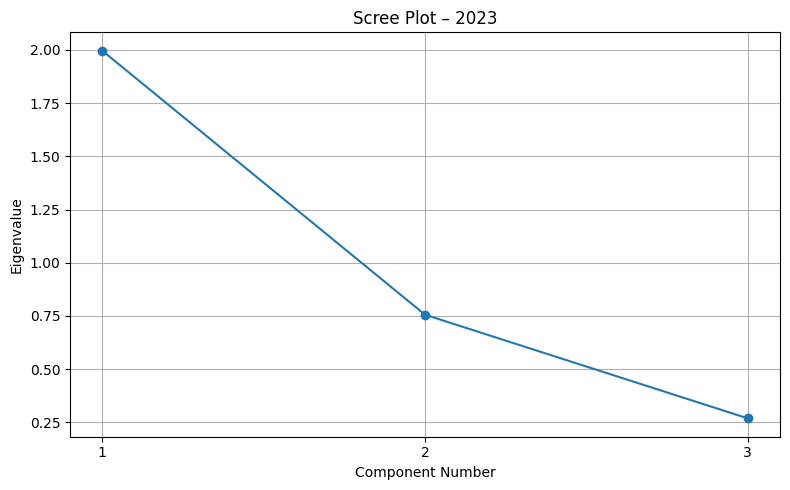

In [88]:
# Scree plot

# Example year
year = 2023
X = df_i[df_i["year"] == year][["broadband_perpop_i", "servers_perpop_i", "internet_users_i"]].dropna()

# Std
X_scaled = (X - X.mean()) / X.std(ddof=0)

# PCA
pca = PCA(n_components=X_scaled.shape[1])
pca.fit(X_scaled)

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o')
plt.title(f"Scree Plot – {year}")
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
plt.xticks(range(1, len(pca.explained_variance_) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
# Merge to dataset
df_pca_i = ex_final_pca_i.merge(pca_index_panel, on = ['country_i','year'],how='left' )

### Partners (country_j)

In [ ]:
# Importers
cols_to_fill = ['broadband_perpop_j', 'servers_perpop_j', 'internet_users_j']

# Sorting
df_pca_i = df_pca_i.sort_values(['country_j', 'year'])

# Interpolacja + ffill + bfill
for col in cols_to_fill:
    df_pca_i[col] = (
        df_pca_i.groupby('country_j')[col]
        .transform(lambda x: x.interpolate(method='linear').ffill().bfill())
    )

# Nans in PCA cols
cols_pcaj = ['broadband_perpop_j', 'servers_perpop_j', 'internet_users_j']
pca_nans_j = df_pca_i[df_pca_i[cols_pcaj].isna().any(axis=1)]
pca_nans_j['country_j'].unique()

ex_final_pca_j = df_pca_i.dropna(subset=cols_pcaj)

In [92]:
df_j = ex_final_pca_j[['country_j', 'year', 'broadband_perpop_j', 'servers_perpop_j', 'internet_users_j']] \
    .drop_duplicates(subset=['country_j', 'year'])

#for PCA: broadband_perpop_i, servers_perpop_, internet_users_i

results = []

for year, group in df_j.groupby("year"):
    # Data
    X = group[["broadband_perpop_j", "servers_perpop_j", "internet_users_j"]].copy()
    X = X.dropna()
    
    if X.empty:
        continue  

    # Standarization
    X_scaled = (X - X.mean()) / X.std(ddof=0)
    
    # PCA
    pca = PCA(n_components=1)
    scores = pca.fit_transform(X_scaled)

    # Index 
    group_clean = group.loc[X.index].copy()
    group_clean["pca_indexj"] = scores

    # Normalization
    group_clean["pca_index_normj"] = (
        (group_clean["pca_indexj"] - group_clean["pca_indexj"].min()) /
        (group_clean["pca_indexj"].max() - group_clean["pca_indexj"].min()) * 100
    )

    results.append(group_clean[["country_j", "year", "pca_indexj", "pca_index_normj"]])

# Merge
pca_index_panelj = pd.concat(results).reset_index(drop=True)

In [93]:
# Eigenvalues

eigen_tables = []

for year, group in df_j.groupby("year"):
    X = group[["broadband_perpop_j", "servers_perpop_j", "internet_users_j"]].copy()
    X = X.dropna()

    if X.empty:
        continue

    # Std
    X_scaled = (X - X.mean()) / X.std(ddof=0)

    # PCA
    pca = PCA(n_components=3)
    pca.fit(X_scaled)

    # PCA Stats
    eigenvalues = pca.explained_variance_
    eigen_diffs = [eigenvalues[i] - eigenvalues[i+1] for i in range(len(eigenvalues)-1)] + [None]
    prop_var = pca.explained_variance_ratio_
    cum_var = prop_var.cumsum()

    df_eigen_year = pd.DataFrame({
        "year": year,
        "Component": [f"Comp{i+1}" for i in range(3)],
        "Eigenvalue": eigenvalues,
        "Difference": eigen_diffs,
        "Proportion of Variance": prop_var,
        "Cumulative Variance": cum_var
    })

    eigen_tables.append(df_eigen_year)

# Merge
eigen_summary_all_years = pd.concat(eigen_tables).reset_index(drop=True)

In [ ]:
# Loadings

loadings_all_years = []

for year, group in df_j.groupby("year"):
    X = group[["broadband_perpop_j", "servers_perpop_j", "internet_users_j"]].copy()
    X = X.dropna()

    if X.empty:
        continue

    # Std
    X_scaled = (X - X.mean()) / X.std(ddof=0)

    # PCA
    pca = PCA(n_components=3)
    pca.fit(X_scaled)

    # Loadings (eigenvectors)
    loadings = pd.DataFrame(pca.components_.T,
                            columns=[f"Comp{i+1}" for i in range(3)],
                            index=["broadband_perpop_j", "servers_perpop_j", "internet_users_j"])
    
    loadings["year"] = year
    loadings["variable"] = loadings.index

    loadings_all_years.append(loadings.reset_index(drop=True))
# Merge
loadings_all_years_df = pd.concat(loadings_all_years).reset_index(drop=True)


In [96]:
# KMO

kmo_list = []

for year, group in df_j.groupby("year"):
    X = group[["broadband_perpop_j", "servers_perpop_j", "internet_users_j"]].copy()
    X = X.dropna()

    if X.empty:
        continue

    # Std
    X_scaled = (X - X.mean()) / X.std(ddof=0)

    # KMO
    kmo_all, kmo_model = calculate_kmo(X_scaled)

    kmo_summary = {"year": year, "KMO_overall": kmo_model}

    for var, val in zip(X.columns, kmo_all):
        kmo_summary[f"KMO_{var}"] = val

    kmo_list.append(kmo_summary)

# Merge
kmo_df = pd.DataFrame(kmo_list).sort_values("year").reset_index(drop=True)

In [97]:
# Merge to dataset
df_pca_j = ex_final_pca_j.merge(pca_index_panelj, on = ['country_j','year'],how='left' )

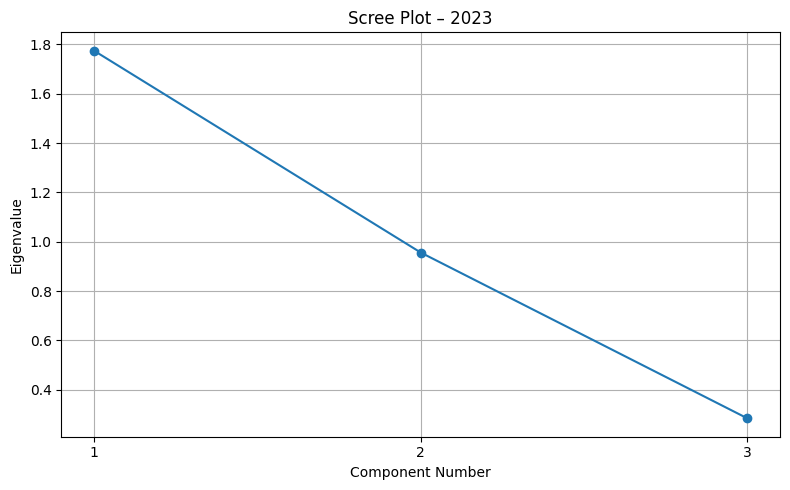

In [98]:
# Screeplot

# Example year 2023
year = 2023
X = df_j[df_j["year"] == year][["broadband_perpop_j", "servers_perpop_j", "internet_users_j"]].dropna()

# Std
X_scaled = (X - X.mean()) / X.std(ddof=0)

# PCA
pca = PCA(n_components=X_scaled.shape[1])
pca.fit(X_scaled)

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o')
plt.title(f"Scree Plot – {year}")
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
plt.xticks(range(1, len(pca.explained_variance_) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Infra Distance (absolute difference)

In [99]:
df_pca_j['infra_dist_pca'] = (df_pca_j['pca_index'] - df_pca_j['pca_indexj']).abs()
df_pca_j['infra_dist_pcanorm'] = (df_pca_j['pca_index_norm'] - df_pca_j['pca_index_normj']).abs()

df_pca_j['ready_dist'] = (df_pca_j['ftri_i_overall'] - df_pca_j['ftri_j_overall']).abs()

## Missing data investigation 

In [100]:
# Percent nans per variable
missing_overall = df_pca_j.isna().mean().sort_values(ascending=False) * 100

# Percent nans per country and exports source
missing_by_country = df_pca_j.groupby('country_i').apply(lambda df: df.isna().mean()).mean(axis=1).sort_values(ascending=False)
missing_by_partner = df_pca_j.groupby('country_j').apply(lambda df: df.isna().mean()).mean(axis=1).sort_values(ascending=False)

# Countries/years with missings
remove = ['Andorra', 'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Burundi', 'China, Macao SAR', 'China, Taiwan Province of', 'Christmas Island', 'Cocos (Keeling) Islands', 'Comoros', 'Cook Islands', 'Curacao', "Dem. People's Rep. of Korea", 'Dominica', 'Equatorial Guinea', 'Eritrea', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Polynesia', 'Gibraltar', 'Greenland', 'Grenada', 'Guinea-Bissau', 'Kiribati', 'Lesotho', 'Marshall Islands', 'Micronesia (Federated States of)', 'Montserrat', 'Nauru', 'New Caledonia', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Palau', 'Pitcairn', 'Saint Helena', 'Saint Kitts and Nevis', 'Saint Pierre and Miquelon', 'San Marino', 'Seychelles', 'Somalia', 'State of Palestine', 'Syrian Arab Republic', 'Tokelau', 'Tonga', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'Wallis and Futuna Islands', 'Western Sahara']
df_cleaned = df_pca_j[~df_pca_j['country_i'].isin(remove) & ~df_pca_j['country_j'].isin(remove)]
df = df_cleaned[df_cleaned['year'] > 2013]

/var/folders/mz/q4b66zqd3xq8pwzks5kk1bkw0000gn/T/ipykernel_8625/1033347504.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_country = df_pca_j.groupby('country_i').apply(lambda df: df.isna().mean()).mean(axis=1).sort_values(ascending=False)
/var/folders/mz/q4b66zqd3xq8pwzks5kk1bkw0000gn/T/ipykernel_8625/1033347504.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_partner = df_pca_

In [ ]:
# Additional checks
nan_percentages = df.groupby('country_j')['ready_dist'].apply(lambda x: x.isna().mean() * 100)
nan_percentages_sorted = nan_percentages.sort_values(ascending=False)


# FTRI quartile

In [104]:
# Exporters

# Grouping, avg FTRI
mean_ftri = df.groupby(['year', 'country_i'])['ftri_i_overall'].mean().reset_index()
mean_ftri.rename(columns={'ftri_i_overall': 'mean_ftri_i'}, inplace=True)

# Upper quartile (75%)
mean_ftri['high_ftri_q75_i'] = mean_ftri.groupby('year')['mean_ftri_i']\
    .transform(lambda x: x > x.quantile(0.75)).astype(int)


# Merge 
df_final = df.merge(
    mean_ftri[['year', 'country_i', 'high_ftri_q75_i']],
    on=['year', 'country_i'],
    how='left'
)

# Importers

# Grouping, avg FTRI
mean_ftri = df_final.groupby(['year', 'country_j'])['ftri_j_overall'].mean().reset_index()
mean_ftri.rename(columns={'ftri_j_overall': 'mean_ftri_j'}, inplace=True)

# Upper quartile (75%)
mean_ftri['high_ftri_q75_j'] = mean_ftri.groupby('year')['mean_ftri_j']\
    .transform(lambda x: x > x.quantile(0.75)).astype(int)

# Merge
df_final01 = df_final.merge(
    mean_ftri[['year', 'country_j',  'high_ftri_q75_j']],
    on=['year', 'country_j'],
    how='left'
)